In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import psycopg2.extras
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1️⃣ Build a Clean Feature Set per Item

At the item_id level, you should compute:
avg_monthly_sales 
cv_sales
freq_ratio
unit_cost (optional if you have)
lead_time (optional)
avg_line_cost

In [2]:
df = pd.read_csv('../data/antal_consegne23_24.xlsx - Dettaglio ordini e consegne.csv')
df = df[['so_date', 'item_id', 'so_quantity', 'actual_lt']]
df = df.rename(columns={'so_quantity':'quantity', 'actual_lt':'lt'})
df = df.drop(df[df.so_date == ' '].index) # include only sold lines
df = df.drop(df[(df['so_date'] < '2023-01-01') | (df['so_date'] > '2025-02-28')].index)

df.so_date = pd.to_datetime(df.so_date)
df['month'] = df.so_date.dt.to_period('M')

df['lt'] = df['lt'].astype(str).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28488 entries, 0 to 32533
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   so_date   28488 non-null  datetime64[ns]
 1   item_id   28488 non-null  object        
 2   quantity  28488 non-null  int64         
 3   lt        28488 non-null  int64         
 4   month     28488 non-null  period[M]     
dtypes: datetime64[ns](1), int64(2), object(1), period[M](1)
memory usage: 1.3+ MB


In [3]:
# cost
cost = pd.read_csv('../data/antal_article_value.csv', decimal='.', thousands=',')
cost = cost[['category', 'item_id', 'unit_value']]
cost = cost.rename(columns={'unit_value':'unit_cost'})
cost['unit_cost'] = cost['unit_cost'].astype(str).astype(float)
cost = cost.drop_duplicates('item_id', keep='first') # keep only recent values
cost.head()
cost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1977 entries, 0 to 3994
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   category   1977 non-null   object 
 1   item_id    1977 non-null   object 
 2   unit_cost  1976 non-null   float64
dtypes: float64(1), object(2)
memory usage: 61.8+ KB


## Merge and wrangle data

In [4]:
mdf = df.merge(cost.drop_duplicates('item_id', keep='first'), how='left')
mdf = mdf[mdf.unit_cost > 0] # keep only items that have a price
#mdf = mdf[mdf.unit_cost <= 200] # keep only items that have a low price
mdf['line_cost'] = mdf.quantity * mdf.unit_cost
mdf.info()
mdf

<class 'pandas.core.frame.DataFrame'>
Index: 25500 entries, 0 to 28487
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   so_date    25500 non-null  datetime64[ns]
 1   item_id    25500 non-null  object        
 2   quantity   25500 non-null  int64         
 3   lt         25500 non-null  int64         
 4   month      25500 non-null  period[M]     
 5   category   25500 non-null  object        
 6   unit_cost  25500 non-null  float64       
 7   line_cost  25500 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2), period[M](1)
memory usage: 1.8+ MB


,so_date,item_id,quantity,lt,month,category,unit_cost,line_cost
0,2024-04-24,00517,2,35,2024-04,Rinvii (95),24.68,49.36
1,2024-04-24,00818Z,3,35,2024-04,Rinvii (95),98.25,294.75
2,2024-04-24,04919F,2,35,2024-04,Pulegge (90),24.49,48.98
3,2024-04-24,10021A,2,35,2024-04,Pulegge (90),45.87,91.74
4,2024-04-24,501.110,8,35,2024-04,Stopper (120),48.53,388.24
...,...,...,...,...,...,...,...,...
28483,2023-06-05,HS22.40S,5,12,2023-06,Full Batten (50),21.28,106.40
28484,2023-08-29,R07.05,10,4,2023-08,Soft Link (110),5.49,54.90
28485,2023-08-29,R10.07,10,4,2023-08,Soft Link (110),6.53,65.30
28486,2023-08-29,R14.10,10,4,2023-08,Soft Link (110),7.66,76.60


<Axes: >

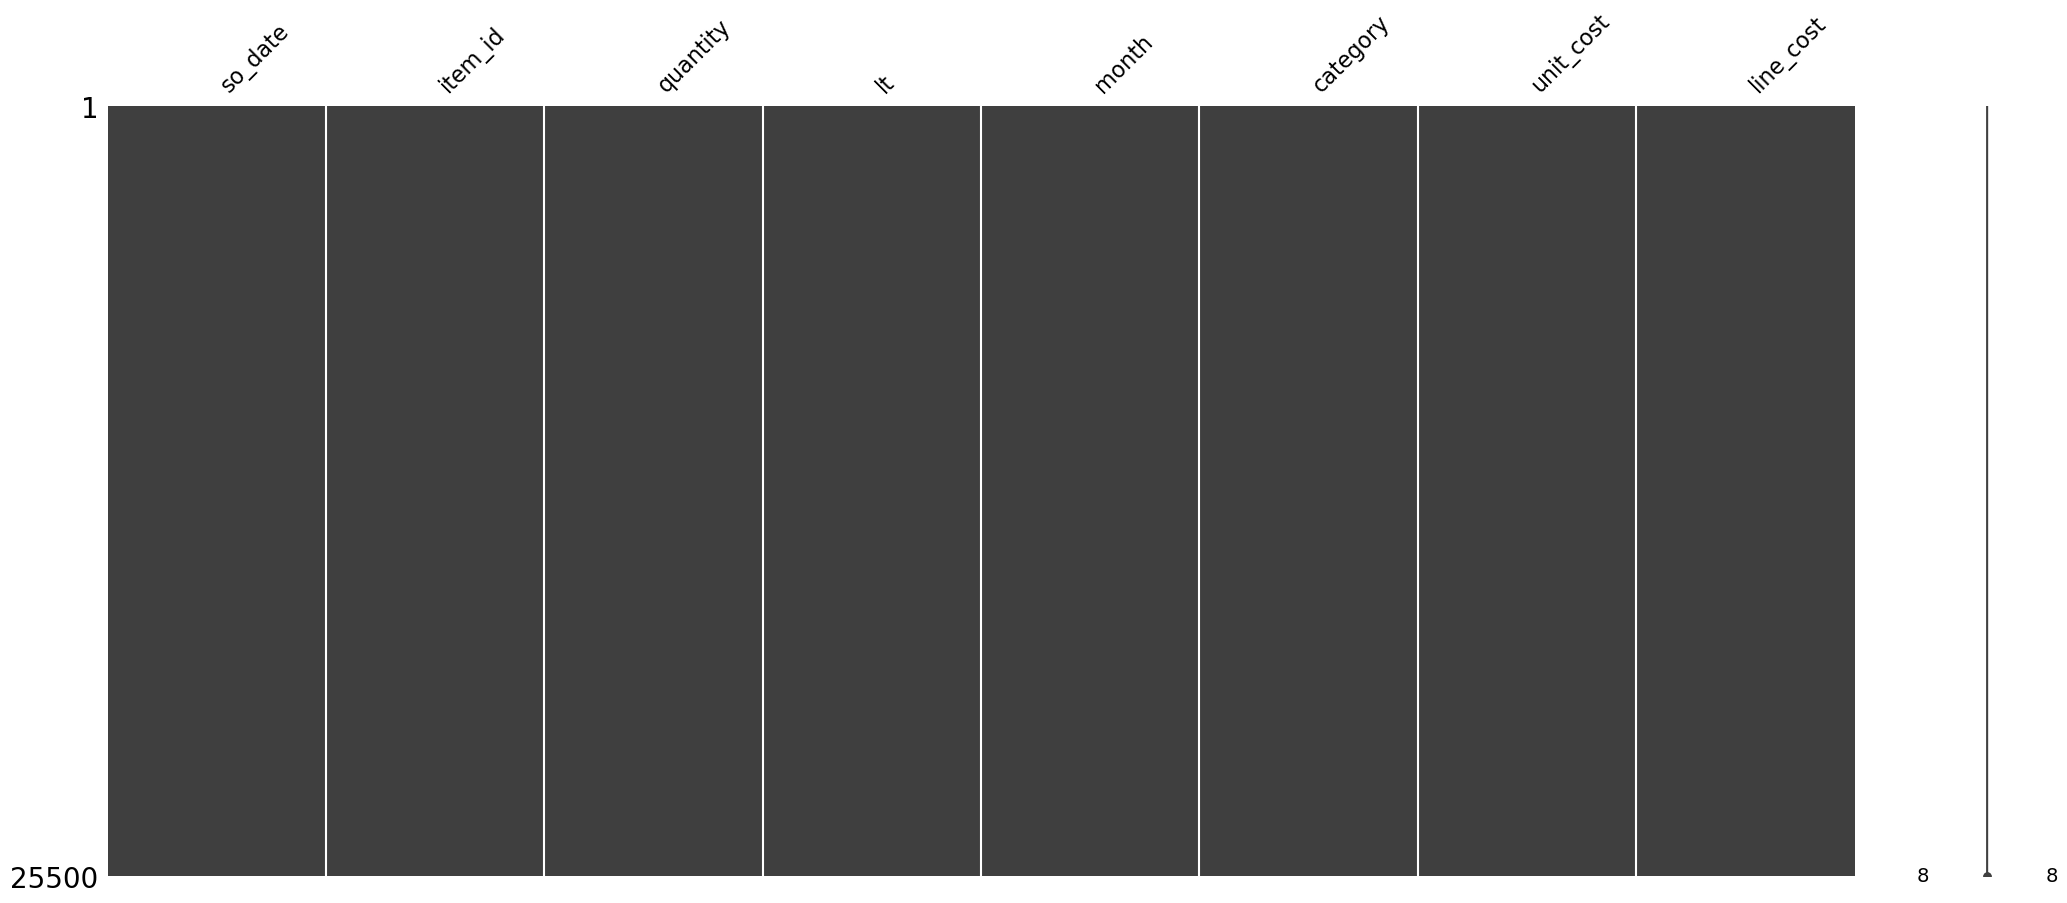

In [5]:
msno.matrix(mdf)

In [6]:
# dropping null cost items makes sense - they are all uncategoried, too (probably mostly Y- articles)
# the result is dropping 995 unique articles or about 3600 lines
no_costs = mdf[mdf.unit_cost.isna()]
no_costs = no_costs[['item_id', 'category']].drop_duplicates().fillna('unknown')
agg = no_costs.groupby('category').category.size()
agg

Series([], Name: category, dtype: int64)

In [7]:
# create a full article-date set
items = mdf.item_id.unique()
mdf['month'] = mdf.so_date.dt.to_period('M')
months = pd.period_range(mdf.month.min(), mdf.month.max(), freq='M')
full_index = pd.MultiIndex.from_product([items, months], names=['item_id', 'month'])

#group by month
monthly_sales = (mdf.groupby(['item_id', 'month'])
                 .agg(
                    quantity=("quantity", "sum"),
                    avg_lt=('lt', 'mean'),
                    avg_unit_cost=('unit_cost', 'mean')
                    )
                 .reset_index())

sales = (monthly_sales.set_index(['item_id', 'month'])
         .reindex(full_index)
         .reset_index())

sales['quantity'] = sales['quantity'].fillna(0) # avg_lt, avg_unit_cost, avg_line_cost stay NaN
sales['avg_line_cost'] = sales.avg_unit_cost * sales.quantity # recompute the average line cost


sales = pd.merge(sales, cost[['item_id', 'category']].drop_duplicates(keep='first'), how='left')

print(len(sales))
print(sales.info())
sales.head()

48074
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48074 entries, 0 to 48073
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   item_id        48074 non-null  object   
 1   month          48074 non-null  period[M]
 2   quantity       48074 non-null  float64  
 3   avg_lt         12108 non-null  float64  
 4   avg_unit_cost  12108 non-null  float64  
 5   avg_line_cost  12108 non-null  float64  
 6   category       48074 non-null  object   
dtypes: float64(4), object(2), period[M](1)
memory usage: 2.6+ MB
None


,item_id,month,quantity,avg_lt,avg_unit_cost,avg_line_cost,category
0,00517,2023-01,0.0,NaN,NaN,NaN,Rinvii (95)
1,00517,2023-02,2.0,26.0,24.68,49.36,Rinvii (95)
2,00517,2023-03,0.0,NaN,NaN,NaN,Rinvii (95)
3,00517,2023-04,0.0,NaN,NaN,NaN,Rinvii (95)
4,00517,2023-05,4.0,16.0,24.68,98.72,Rinvii (95)


<Axes: >

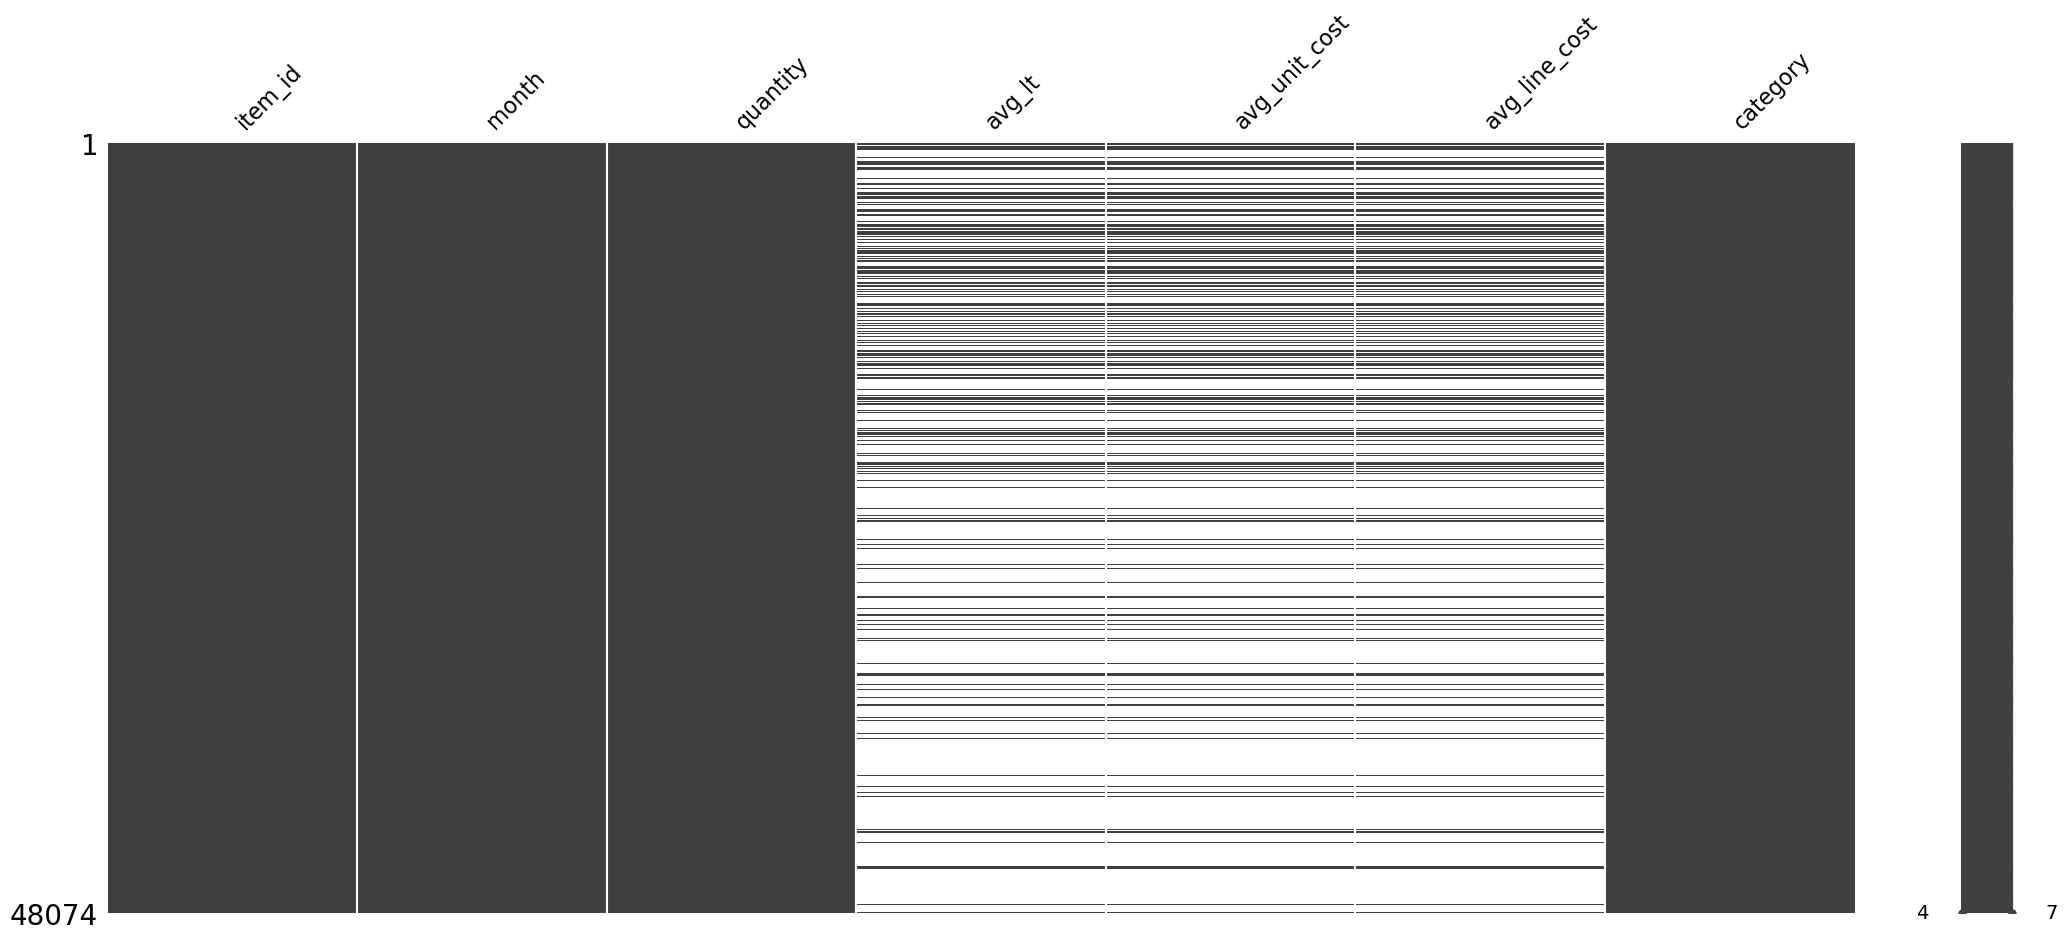

In [8]:
msno.matrix(sales)

# Build the monthly statistics dataset

In [9]:
stats = (sales.groupby(['category', 'item_id'])
         .agg(avg_monthly_sales=("quantity", "mean"), 
                    std=("quantity", "std"),
                    avg_unit_cost=('avg_unit_cost', 'mean'),
                    avg_lead_time=('avg_lt', 'mean')
                    )
         .reset_index())
stats['avg_total_value'] = stats.avg_monthly_sales * stats.avg_unit_cost
stats['cv_sales'] = stats['std'] / stats['avg_monthly_sales'].replace(0, np.nan)


n_months = sales.month.nunique()
freq_ratio = (
    sales.groupby('item_id')['quantity']
    .apply(lambda x: (x>0).sum())
    /n_months
)
freq_ratio = freq_ratio.to_frame().reset_index()
freq_ratio = freq_ratio.rename(columns={'quantity':'freq_ratio'})
stats = pd.merge(stats, freq_ratio, how='left', on='item_id')

stats = stats.drop(columns=['std'])
stats.head()

,category,item_id,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio
0,Accessori (10),005LS,0.192308,2.12,0.000000,0.407692,5.099020,0.038462
1,Accessori (10),005SS,0.307692,2.20,2.000000,0.676923,5.099020,0.038462
2,Accessori (10),006HR,1.500000,9.50,23.000000,14.250000,2.152002,0.230769
3,Accessori (10),006SS,0.615385,2.12,16.833333,1.304615,2.981401,0.115385
4,Accessori (10),008HR,2.653846,14.55,20.981481,38.613462,1.747828,0.346154


<Axes: >

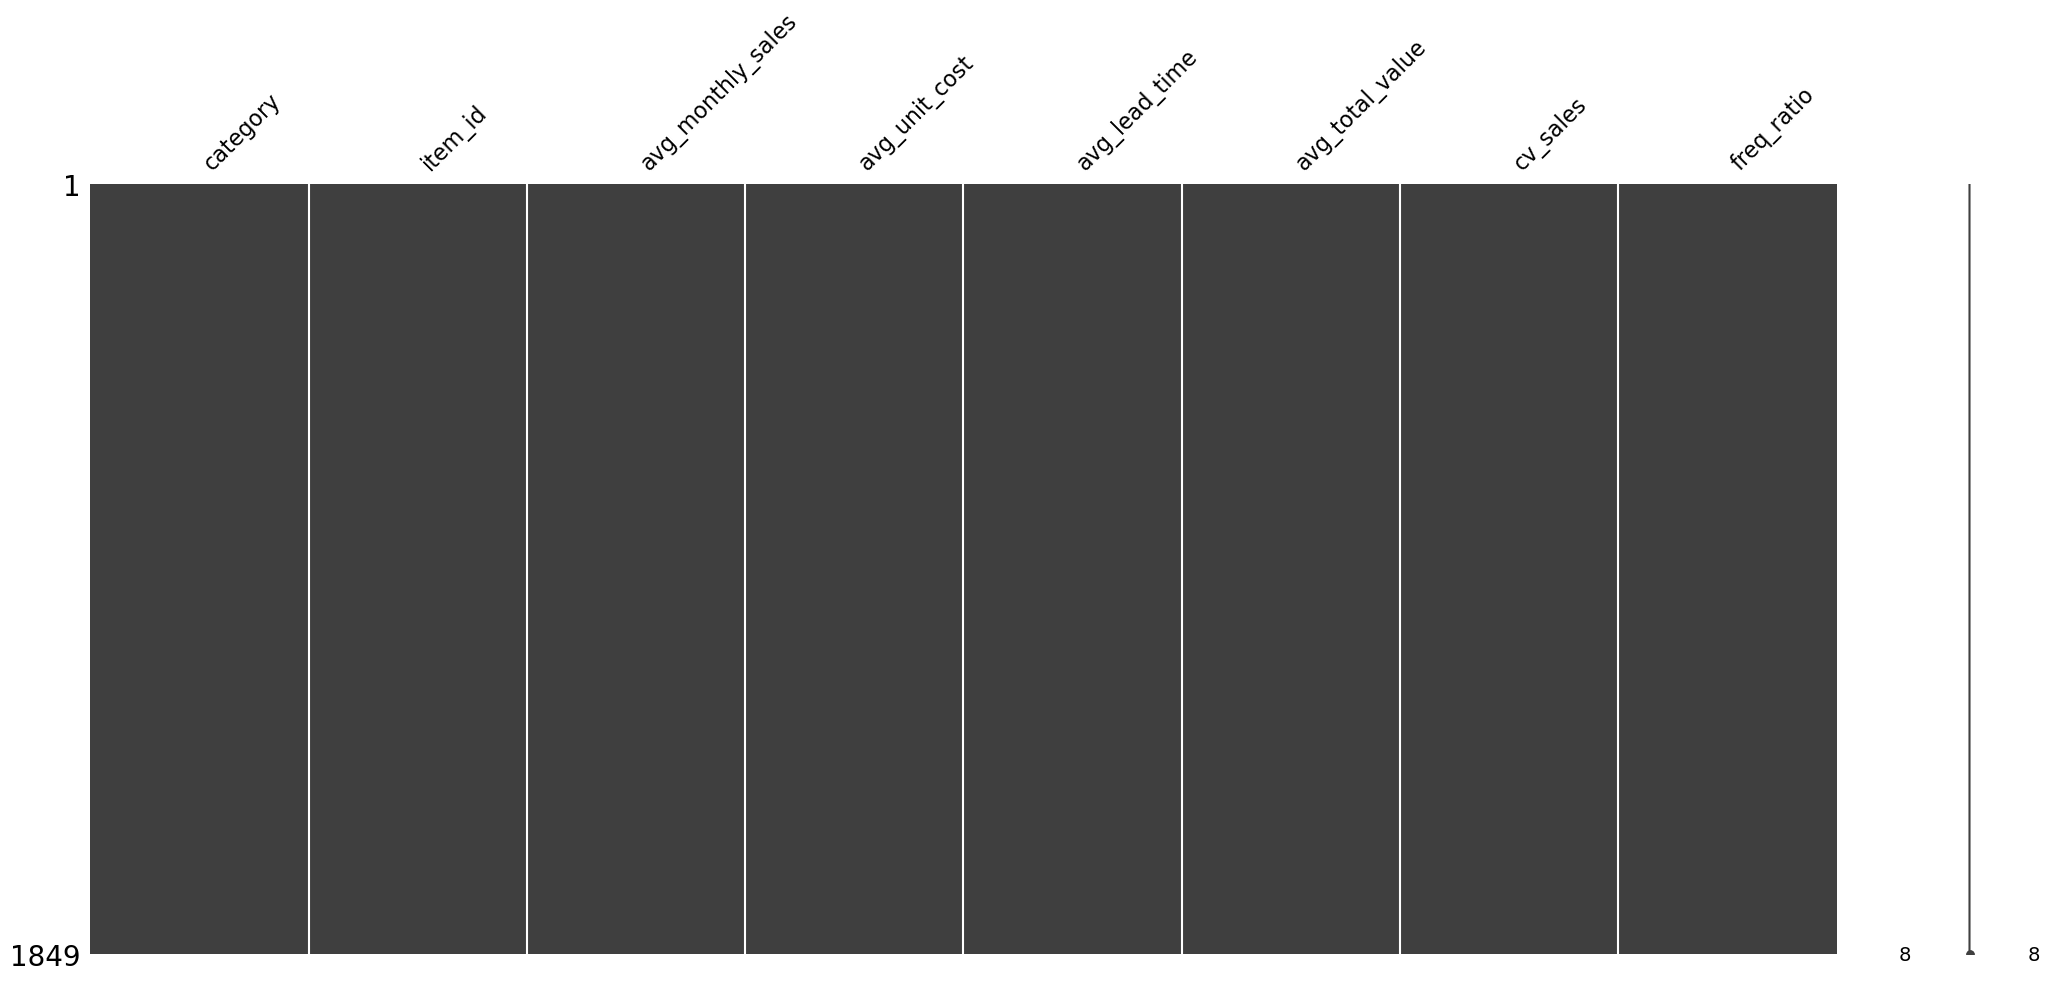

In [10]:
msno.matrix(stats)

# 3️⃣ Exploratory Data Analysis (EDA)
	•	Histograms of sales_value, avg_monthly_sales, unit_cost
	•	Scatterplots: avg_monthly_sales vs. cv_sales, unit_cost vs. frequency
	•	Identify:
	•	Outliers (huge volume or price)
	•	“Dead” items (rare/no sales)
	•	“Noisy” items (unstable sales)



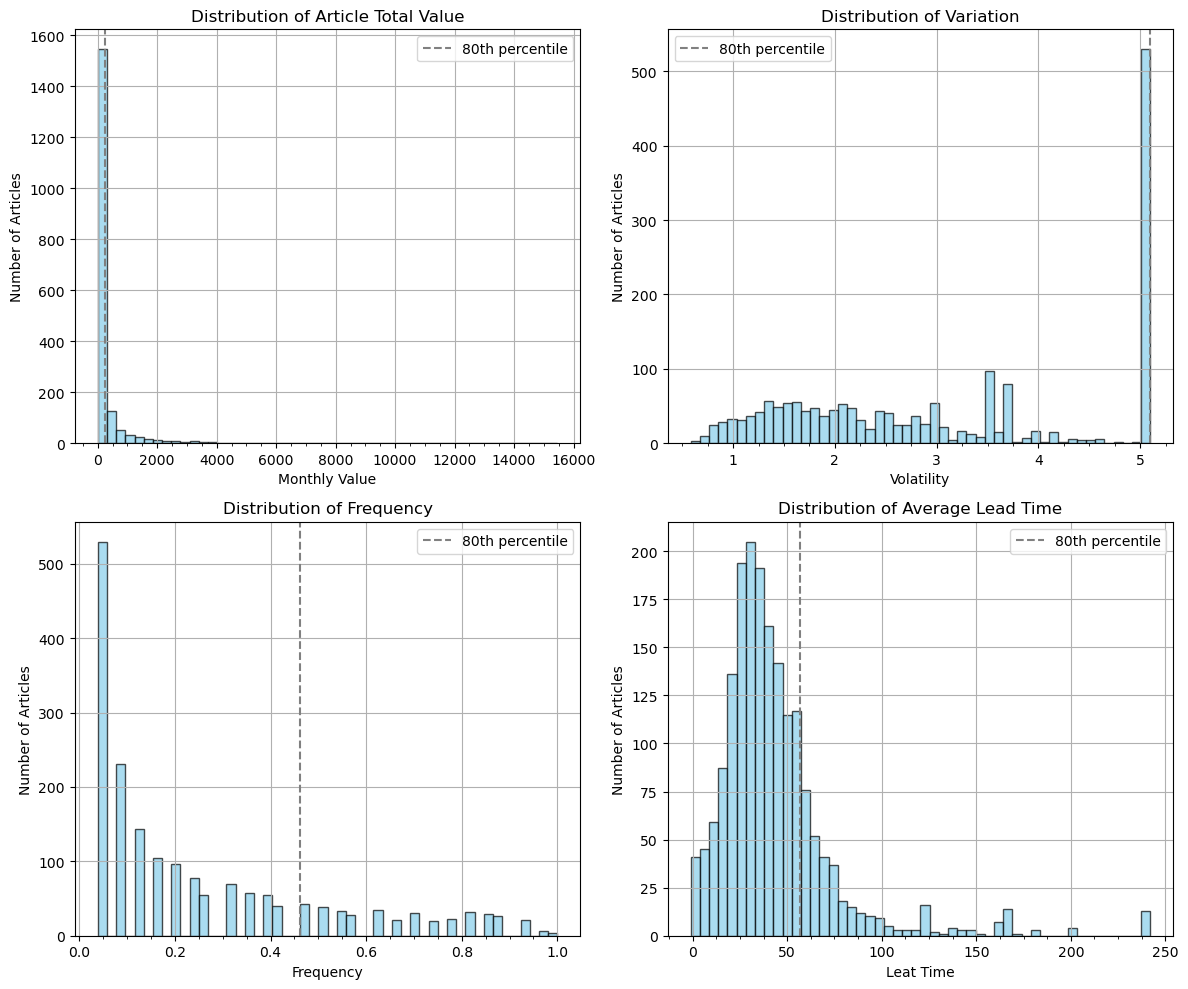

In [11]:
# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Unpack axes for easy handling
(ax1, ax2), (ax3, ax4) = axes

# First plot: avg_total_value
ax1.hist(stats['avg_total_value'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of Article Total Value')
ax1.set_xlabel('Monthly Value')
ax1.set_ylabel('Number of Articles')
ax1.grid(True)
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))  # 2 minor ticks between majors
q80 = stats['avg_total_value'].quantile(0.8)
ax1.axvline(q80, color='grey', linestyle='--', label='80th percentile')
ax1.legend()


# Second plot: cv_sales
ax2.hist(stats['cv_sales'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of Variation')
ax2.set_xlabel('Volatility')
ax2.set_ylabel('Number of Articles')
ax2.grid(True)
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
q80 = stats['cv_sales'].quantile(0.8)
ax2.axvline(q80, color='grey', linestyle='--', label='80th percentile')
ax2.legend()

# Third plot: freq_ratio
ax3.hist(stats['freq_ratio'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax3.set_title('Distribution of Frequency')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Number of Articles')
ax3.grid(True)
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
q80 = stats['freq_ratio'].quantile(0.8)
ax3.axvline(q80, color='grey', linestyle='--', label='80th percentile')
ax3.legend()

# Fourth plot: avg_lead_time
ax4.hist(stats['avg_lead_time'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax4.set_title('Distribution of Average Lead Time')
ax4.set_xlabel('Leat Time')
ax4.set_ylabel('Number of Articles')
ax4.grid(True)
ax4.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
q80 = stats['avg_lead_time'].quantile(0.8)
ax4.axvline(q80, color='grey', linestyle='--', label='80th percentile')
ax4.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [12]:
stats


,category,item_id,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio
0,Accessori (10),005LS,0.192308,2.12,0.000000,0.407692,5.099020,0.038462
1,Accessori (10),005SS,0.307692,2.20,2.000000,0.676923,5.099020,0.038462
2,Accessori (10),006HR,1.500000,9.50,23.000000,14.250000,2.152002,0.230769
3,Accessori (10),006SS,0.615385,2.12,16.833333,1.304615,2.981401,0.115385
4,Accessori (10),008HR,2.653846,14.55,20.981481,38.613462,1.747828,0.346154
...,...,...,...,...,...,...,...,...
1844,Winch XT (200),XT76EV24AL,0.076923,4978.80,61.000000,382.984615,5.099020,0.038462
1845,Winch XT (200),XT80.3AL,0.076923,4693.68,103.000000,361.052308,5.099020,0.038462
1846,Winch XT (200),XT80.3EH24CH,0.153846,12617.64,93.000000,1941.175385,3.982462,0.076923
1847,Winch XT (200),XT80.3HDCH,0.153846,12421.80,142.500000,1911.046154,3.532704,0.076923


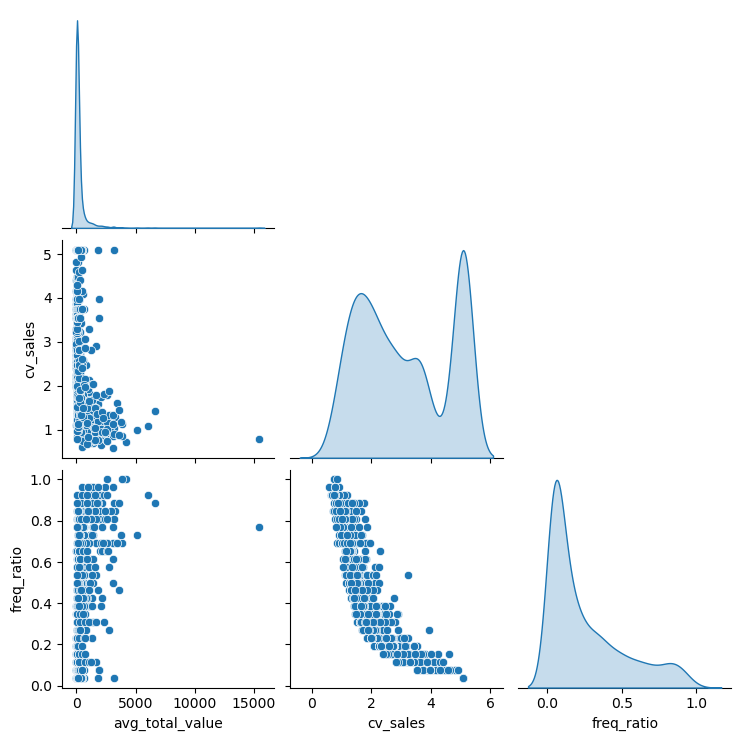

In [13]:
pplot_features = ['avg_total_value', 'cv_sales', 'freq_ratio']
sns.pairplot(
    data=stats,
    vars=pplot_features,
    corner=True,
    diag_kind='kde'
)

In [14]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849 entries, 0 to 1848
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category           1849 non-null   object 
 1   item_id            1849 non-null   object 
 2   avg_monthly_sales  1849 non-null   float64
 3   avg_unit_cost      1849 non-null   float64
 4   avg_lead_time      1849 non-null   float64
 5   avg_total_value    1849 non-null   float64
 6   cv_sales           1849 non-null   float64
 7   freq_ratio         1849 non-null   float64
dtypes: float64(6), object(2)
memory usage: 115.7+ KB


## Anomalies 

In [15]:
# Example: Top 1% of items by average monthly sales
outliers_sales = stats[stats['avg_monthly_sales'] > stats['avg_monthly_sales'].quantile(0.99)] # these are the BULLETS

# Items with huge unit cost
outliers_cost = stats[(stats['avg_unit_cost'] > stats['avg_unit_cost'].quantile(0.98)) & (~stats['item_id'].isin(outliers_sales['item_id']))] # out of ordinary unit_cost

# items with poor stability and low frequency
noisy_items = stats[(stats['cv_sales'] > 2) & (stats['freq_ratio'] < 0.4) & (~stats['item_id'].isin(outliers_cost['item_id']))] # NOISY items that don't sell

outliers_summary = []

for idx, row in outliers_sales.iterrows():
    outliers_summary.append({'outlier_type': 'high_sales', 'item_id': row['item_id']})

for idx, row in outliers_cost.iterrows():
    outliers_summary.append({'outlier_type': 'high_cost', 'item_id': row['item_id']})

for idx, row in noisy_items.iterrows():
    outliers_summary.append({'outlier_type': 'noisy_items', 'item_id': row['item_id']})

outliers_summary = pd.DataFrame(outliers_summary)


noutliers = len(outliers_summary['item_id'].unique())
nids = len(stats['item_id'].unique())
print(f'There are {noutliers} outliers and {nids - noutliers} remaining values')
goutliers = outliers_summary.groupby('outlier_type').agg(counts=('outlier_type', 'count'))
display(pd.DataFrame(goutliers).reset_index())

# Group outlier types per item_id into a list (or a string if you prefer)
outliers_summary_grouped = (
    outliers_summary
    .groupby('item_id')['outlier_type']
    .agg(lambda x: ', '.join(x))
    .reset_index()
)
outlier_check = pd.merge(stats, outliers_summary_grouped, how='left', on='item_id').fillna('ok')
outlier_check.to_csv('../data/outlier_check.csv')


There are 1269 outliers and 580 remaining values


,outlier_type,counts
0,high_cost,37
1,high_sales,19
2,noisy_items,1213


In [16]:
raw_features = ['avg_monthly_sales', 'avg_unit_cost', 'avg_lead_time', 'avg_total_value', 'cv_sales', 'freq_ratio']
scaled_features = ['sales_is','unit_cost_s','lt_is','cv_s','freq_ratio_is']

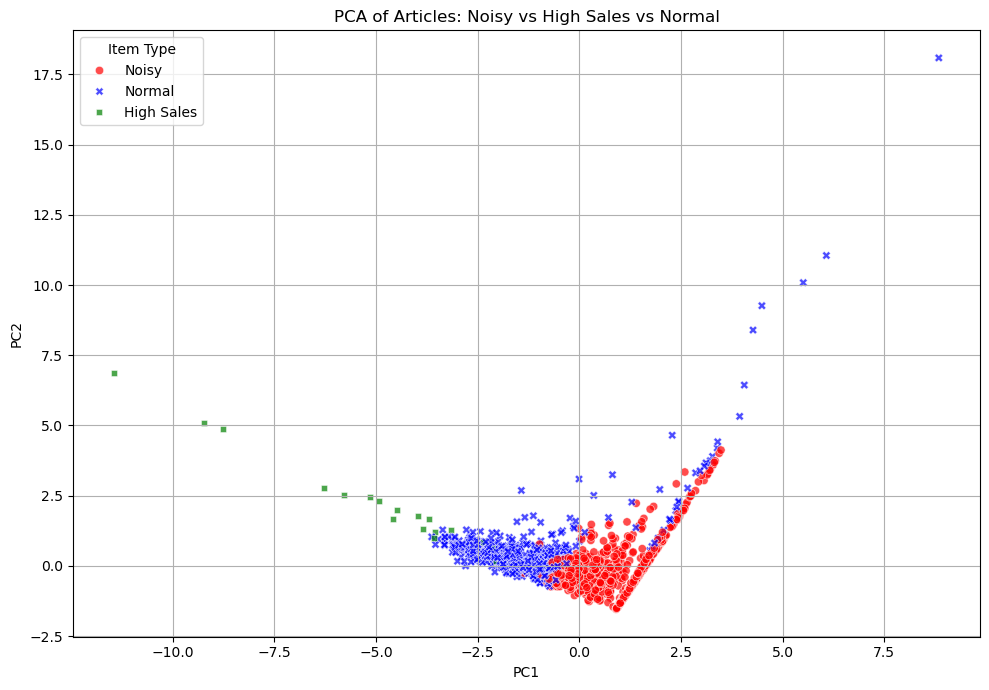

In [17]:
# 1. Create an outlier flag
noisy_items = outliers_summary.loc[outliers_summary.outlier_type == 'noisy_items', 'item_id'].unique()
high_sales_items = outliers_summary.loc[outliers_summary.outlier_type == 'high_sales', 'item_id'].unique()
high_cost_items = outliers_summary.loc[outliers_summary.outlier_type == 'high_cost', 'item_id'].unique()

stats['is_noisy'] = stats['item_id'].isin(noisy_items)
stats['is_high_sales'] = stats['item_id'].isin(high_sales_items)

# 2. Scale features (lower = better logic)
scaler = StandardScaler()
stats['sales_is'] = scaler.fit_transform(-stats[['avg_monthly_sales']])
stats['cv_s'] = scaler.fit_transform(stats[['cv_sales']])
stats['freq_ratio_is'] = scaler.fit_transform(-stats[['freq_ratio']])
stats['unit_cost_s'] = scaler.fit_transform(stats[['avg_unit_cost']])
stats['lt_is'] = scaler.fit_transform(-stats[['avg_lead_time']])

# 3. Select scaled features
scaled_features = ['sales_is', 'cv_s', 'freq_ratio_is', 'unit_cost_s', 'lt_is']
X = stats[scaled_features].dropna()
item_ids = stats.loc[X.index, 'item_id']

# 4. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 5. Build PCA dataframe
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['item_id'] = item_ids.values

# Copy flags directly
pca_df['is_noisy'] = stats.loc[X.index, 'is_noisy'].values
pca_df['is_high_sales'] = stats.loc[X.index, 'is_high_sales'].values

# 6. Assign combined label
def assign_label(row):
    if row['is_noisy']:
        return 'Noisy'
    elif row['is_high_sales']:
        return 'High Sales'
    else:
        return 'Normal'

pca_df['label'] = pca_df.apply(assign_label, axis=1)

# 7. Plot
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='label',
    style='label',
    palette={'Normal': 'blue', 'Noisy': 'red', 'High Sales': 'green'},
    alpha=0.7
)

plt.title('PCA of Articles: Noisy vs High Sales vs Normal')
plt.grid(True)
plt.legend(title='Item Type')
plt.tight_layout()
plt.show()

In [18]:
outlier_check.groupby('outlier_type')[raw_features].mean().round(3).reset_index()

,outlier_type,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio
0,high_cost,0.155,5600.972,94.421,770.788,4.484,0.075
1,high_sales,165.352,14.156,25.774,1959.304,1.140,0.796
2,noisy_items,0.762,256.480,45.822,59.408,3.885,0.104
3,ok,7.390,144.996,36.961,541.738,1.452,0.554


# 2️⃣ Scaling and Inverting Where Necessary

Prepare two views of your features:
	•	Raw features (for interpretation, visuals)
	•	Scaled/Inverted features (for clustering and PCA)

➡️ Make sure higher = “better” before clustering (e.g., high frequency good, low CV good).



In [19]:
stats2 = outlier_check[outlier_check.outlier_type == 'ok']
stats2 = stats2[raw_features + ['category', 'item_id']]

stats2

,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio,category,item_id
4,2.653846,14.55,20.981481,38.613462,1.747828,0.346154,Accessori (10),008HR
16,9.346154,24.94,31.621667,233.093077,1.133123,0.769231,Accessori (10),7206
17,11.307692,31.60,37.585281,357.323077,1.025170,0.846154,Accessori (10),7208
19,13.730769,35.18,45.671212,483.048462,1.137545,0.846154,Accessori (10),7210
20,57.615385,37.23,39.961886,2145.020769,0.826680,0.884615,Accessori (10),7212
...,...,...,...,...,...,...,...,...
1804,0.923077,1753.30,57.875000,1618.430769,1.784657,0.307692,Winch XT (200),XT52EH24AL
1815,1.346154,1167.70,42.211111,1571.903846,1.028095,0.576923,Winch XT (200),XT62AL
1818,1.615385,1905.15,55.406250,3077.550000,1.122194,0.615385,Winch XT (200),XT62EH24AL
1826,0.500000,1533.30,62.916667,766.650000,1.979899,0.230769,Winch XT (200),XT66AL


In [20]:
# lower = better

scaler = StandardScaler()
stats2['sales_is'] = scaler.fit_transform(-stats2[['avg_monthly_sales']]) # more sales = better

scaler = StandardScaler()
stats2['cv_s'] = scaler.fit_transform(stats2[['cv_sales']]) # less coefficient of variation = better

scaler = StandardScaler()
stats2['freq_ratio_is'] = scaler.fit_transform(-stats2[['freq_ratio']]) # higher frequency = better

scaler = StandardScaler()
stats2['unit_cost_s'] = scaler.fit_transform(stats2[['avg_unit_cost']]) # lower unit cost = better

scaler = StandardScaler()
stats2['lt_is'] = scaler.fit_transform(-stats2[['avg_lead_time']]) # lower LT = better

# 4️⃣ Dimensionality Reduction

Apply PCA:
	•	Use scaled and inverted features
	•	Visualize in 2D or 3D
	•	See how articles spread across “stability space”



# 5️⃣ Clustering

Run K-Means on PCA input or directly on scaled features:
	•	Choose k = 3 to 6 to start
	•	Analyze:
	•	Cluster averages
	•	Cluster sizes
	•	Cluster stability patterns

Check:
	•	Are there tight stable clusters?
	•	Are there mixed clusters (stable but high-cost, etc.)?



## Manual distance clustering

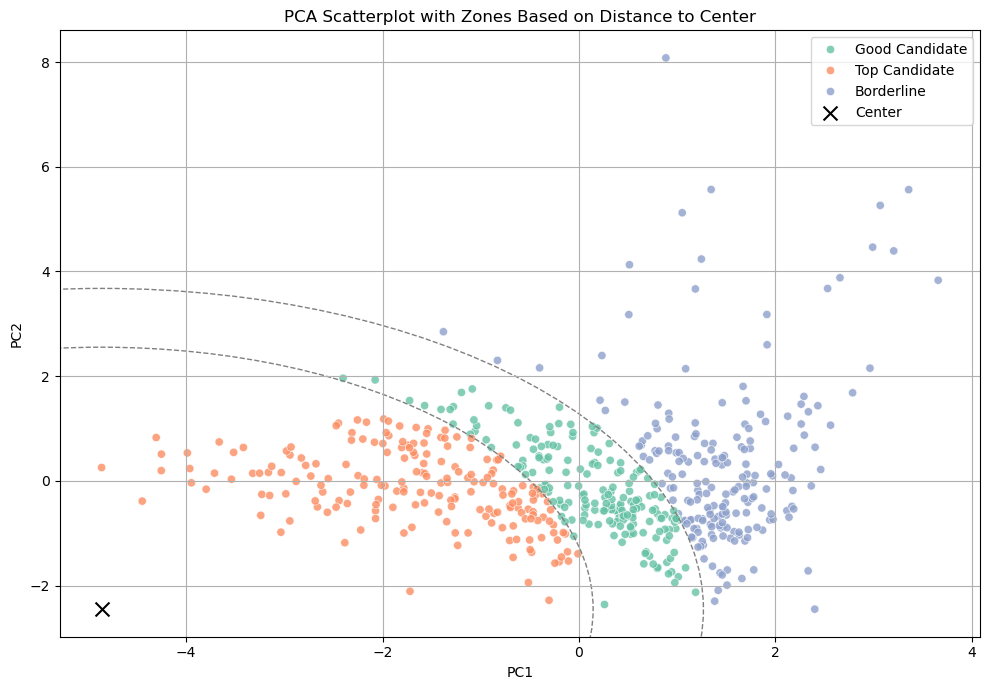

,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio,category,item_id,sales_is,cv_s,freq_ratio_is,unit_cost_s,lt_is,zone
4,2.653846,14.55,20.981481,38.613462,1.747828,0.346154,Accessori (10),008HR,0.443021,0.821101,1.042207,-0.483830,1.176621,Good Candidate
16,9.346154,24.94,31.621667,233.093077,1.133123,0.769231,Accessori (10),7206,-0.182981,-0.884610,-1.082164,-0.445293,0.393139,Top Candidate
17,11.307692,31.60,37.585281,357.323077,1.025170,0.846154,Accessori (10),7208,-0.366464,-1.184163,-1.468413,-0.420590,-0.045987,Top Candidate
19,13.730769,35.18,45.671212,483.048462,1.137545,0.846154,Accessori (10),7210,-0.593120,-0.872340,-1.468413,-0.407312,-0.641389,Top Candidate
20,57.615385,37.23,39.961886,2145.020769,0.826680,0.884615,Accessori (10),7212,-4.698107,-1.734942,-1.661538,-0.399708,-0.220987,Top Candidate


In [21]:
# 1. Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(stats2[scaled_features])

# 2. Build a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# 1. Define center at bottom-left
center_x, center_y = pca_df['PC1'].min(), pca_df['PC2'].min()

# 2. Compute distance of each point to the center
pca_df['distance_to_center'] = np.sqrt((pca_df['PC1'] - center_x)**2 + (pca_df['PC2'] - center_y)**2)

# 3. Set radii based on distance percentiles
r1 = pca_df['distance_to_center'].quantile(0.33)
r2 = pca_df['distance_to_center'].quantile(0.66)

# 4. Classify points based on distance
def classify_zone(d):
    if d <= r1:
        return 'Top Candidate'
    elif d <= r2:
        return 'Good Candidate'
    else:
        return 'Borderline'

pca_df['zone'] = pca_df['distance_to_center'].apply(classify_zone)

# 5. Merge the zone labels back into the original data
data = stats2.copy()  # Safety: don't modify original if needed elsewhere
data['zone'] = pca_df['zone'].values  # Assuming same row order!

# 6. Plot PCA Scatter with zones

plt.figure(figsize=(10, 7))

# Plot scatter
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='zone',
    palette='Set2',
    alpha=0.8
)

# Save original axis limits
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

# Draw concentric circles
for r in [r1, r2]:
    circle = plt.Circle(
        (center_x, center_y),
        radius=r,
        color='grey',
        fill=False,
        linestyle='--',
        linewidth=1.0
    )
    plt.gca().add_patch(circle)

# Mark center point
plt.scatter(center_x, center_y, color='black', marker='x', s=100, label='Center')

# Reset original axis limits
plt.xlim(xlim)
plt.ylim(ylim)

# Final plot formatting
plt.title('PCA Scatterplot with Zones Based on Distance to Center')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Final result
data.head()

In [22]:
outlier_check

,category,item_id,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio,outlier_type
0,Accessori (10),005LS,0.192308,2.12,0.000000,0.407692,5.099020,0.038462,noisy_items
1,Accessori (10),005SS,0.307692,2.20,2.000000,0.676923,5.099020,0.038462,noisy_items
2,Accessori (10),006HR,1.500000,9.50,23.000000,14.250000,2.152002,0.230769,noisy_items
3,Accessori (10),006SS,0.615385,2.12,16.833333,1.304615,2.981401,0.115385,noisy_items
4,Accessori (10),008HR,2.653846,14.55,20.981481,38.613462,1.747828,0.346154,ok
...,...,...,...,...,...,...,...,...,...
1844,Winch XT (200),XT76EV24AL,0.076923,4978.80,61.000000,382.984615,5.099020,0.038462,high_cost
1845,Winch XT (200),XT80.3AL,0.076923,4693.68,103.000000,361.052308,5.099020,0.038462,high_cost
1846,Winch XT (200),XT80.3EH24CH,0.153846,12617.64,93.000000,1941.175385,3.982462,0.076923,high_cost
1847,Winch XT (200),XT80.3HDCH,0.153846,12421.80,142.500000,1911.046154,3.532704,0.076923,high_cost


In [23]:
results = data[['category', 'item_id', 'zone'] + raw_features]
all_candidates = pd.concat([
    data[['category', 'item_id', 'zone'] + raw_features],
    outlier_check[outlier_check.outlier_type == 'high_sales'][['category', 'item_id', 'outlier_type'] + raw_features].rename(columns={'outlier_type': 'zone'})
], axis=0, ignore_index=True)

all_candidates.round(3)

,category,item_id,zone,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio
0,Accessori (10),008HR,Good Candidate,2.654,14.55,20.981,38.613,1.748,0.346
1,Accessori (10),7206,Top Candidate,9.346,24.94,31.622,233.093,1.133,0.769
2,Accessori (10),7208,Top Candidate,11.308,31.60,37.585,357.323,1.025,0.846
3,Accessori (10),7210,Top Candidate,13.731,35.18,45.671,483.048,1.138,0.846
4,Accessori (10),7212,Top Candidate,57.615,37.23,39.962,2145.021,0.827,0.885
...,...,...,...,...,...,...,...,...,...
594,Soft Link (110),R28.20,high_sales,184.654,16.64,20.110,3072.640,0.583,0.962
595,Soft Link (110),R3.14,high_sales,67.654,28.86,30.796,1952.490,1.165,0.923
596,Soft Link (110),RL6.1,high_sales,66.423,21.61,21.871,1435.403,1.058,0.885
597,Stopper (120),509.112,high_sales,154.615,38.87,31.821,6009.900,1.071,0.923


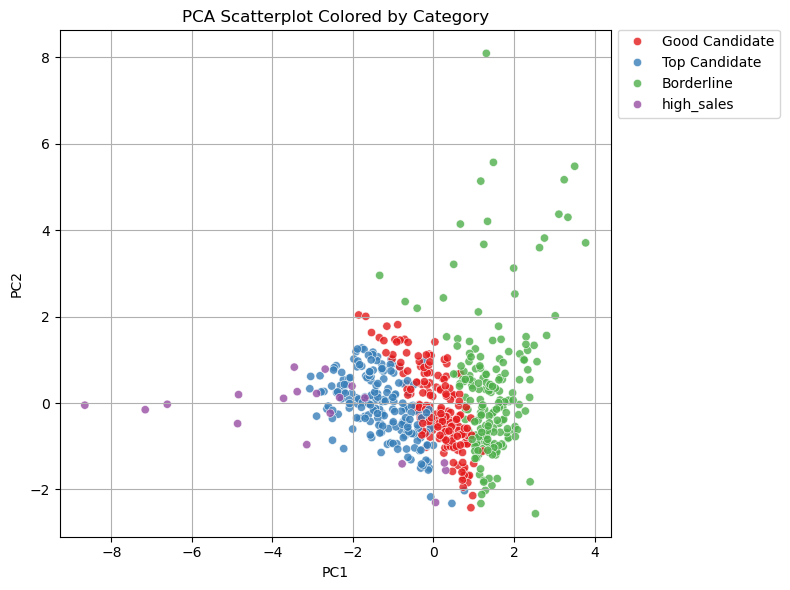

In [24]:
# lower = better

scaler = StandardScaler()
all_candidates['sales_is'] = scaler.fit_transform(-all_candidates[['avg_monthly_sales']]) # more sales = better
all_candidates['cv_s'] = scaler.fit_transform(all_candidates[['cv_sales']]) # less coefficient of variation = better
all_candidates['freq_ratio_is'] = scaler.fit_transform(-all_candidates[['freq_ratio']]) # higher frequency = better
all_candidates['unit_cost_s'] = scaler.fit_transform(all_candidates[['avg_unit_cost']]) # lower unit cost = better
all_candidates['lt_is'] = scaler.fit_transform(-all_candidates[['avg_lead_time']]) # lower LT = better

pca = PCA(n_components=2)
X_pca = pca.fit_transform(all_candidates[scaled_features])

# 2. Build a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['zone'] = all_candidates['zone'].values   # 👈 or any other column you want for hue

# 3. Plot with hue
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='zone',      # 👈 add the hue here
    palette='Set1',
    alpha=0.8
)
plt.legend(bbox_to_anchor=(1, 1.015), loc='upper left')
plt.title('PCA Scatterplot Colored by Category')
plt.grid(True)
plt.tight_layout()
plt.show()

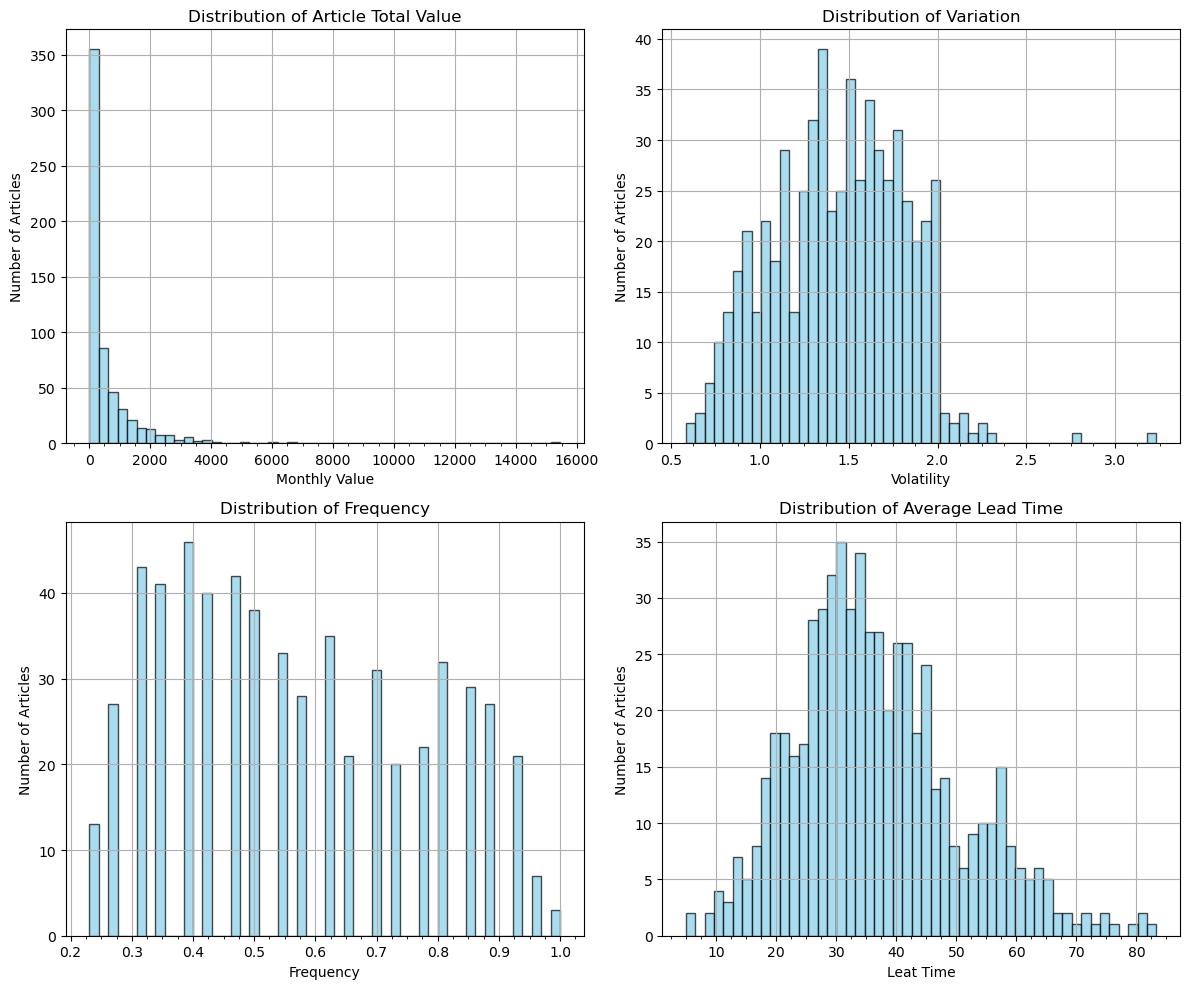

In [25]:
# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Unpack axes for easy handling
(ax1, ax2), (ax3, ax4) = axes

# First plot: avg_total_value
ax1.hist(all_candidates['avg_total_value'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of Article Total Value')
ax1.set_xlabel('Monthly Value')
ax1.set_ylabel('Number of Articles')
ax1.grid(True)
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))  # 2 minor ticks between majors

# Second plot: cv_sales
ax2.hist(all_candidates['cv_sales'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of Variation')
ax2.set_xlabel('Volatility')
ax2.set_ylabel('Number of Articles')
ax2.grid(True)
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))

# Third plot: freq_ratio
ax3.hist(all_candidates['freq_ratio'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax3.set_title('Distribution of Frequency')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Number of Articles')
ax3.grid(True)
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))

# Fourth plot: avg_lead_time
ax4.hist(all_candidates['avg_lead_time'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax4.set_title('Distribution of Average Lead Time')
ax4.set_xlabel('Leat Time')
ax4.set_ylabel('Number of Articles')
ax4.grid(True)
ax4.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))

# Adjust layout
plt.tight_layout()
plt.show()

# 6️⃣ Outlier Analysis

After clustering:
	•	Which points are far from cluster centers?
	•	Any very high unit_cost items that barely sell?
	•	Any super stable but extremely low volume articles?



# 7️⃣ Shortlisting for Stocking

Candidate logic:
	•	High frequency
	•	Low CV
	•	High enough volume (business relevant)
	•	Acceptable unit cost

Define thresholds or select top percentile candidates!

## Rebuild the entire article dataset including outliers

In [26]:
# Quality check
length_noisy = len(noisy_items)
length_coslty = len(high_cost_items)
length_bullets = len(high_sales_items)
length_standard = len(data)
total_lines = length_noisy + length_coslty + length_bullets + length_standard

print(f'The total of standard and outliers is: {total_lines}')
print('')

# 1. Slice and copy
noisy_data = stats[stats.item_id.isin(noisy_items)][['category', 'item_id'] + raw_features].copy()
costly_data = stats[stats.item_id.isin(high_cost_items)][['category', 'item_id'] + raw_features].copy()
bullet_data = stats[stats.item_id.isin(high_sales_items)][['category', 'item_id'] + raw_features].copy()

# 2. Add columns
noisy_data['zone'] = 'Noisy Item'
noisy_data['zone_type'] = 'Outlier'

costly_data['zone'] = 'Costly Item'
costly_data['zone_type'] = 'Outlier'

bullet_data['zone'] = 'Bullet Item'
bullet_data['zone_type'] = 'Outlier'

# 3. Candidates
candidates_data = data[['category', 'item_id', 'zone'] + raw_features].copy()
candidates_data['zone_type'] = 'Standard'

# 4. Merge
all_data = pd.concat([
    candidates_data,
    noisy_data,
    costly_data,
    bullet_data
], axis=0, ignore_index=True)

all_data = all_data.round(3)

# 5. Quick check
print(all_data['zone'].value_counts())
print('')
print(f'Total lines in the all_data set: {len(all_data)}')

all_data.groupby(['zone_type', 'zone']).size()

The total of standard and outliers is: 1849

zone
Noisy Item        1213
Borderline         197
Top Candidate      192
Good Candidate     191
Costly Item         37
Bullet Item         19
Name: count, dtype: int64

Total lines in the all_data set: 1849


zone_type  zone          
Outlier    Bullet Item         19
           Costly Item         37
           Noisy Item        1213
Standard   Borderline         197
           Good Candidate     191
           Top Candidate      192
dtype: int64

In [ ]:

all_data = all_data[['category', 'item_id', 'zone_type', 'zone'] + raw_features]

order_principle = ['Top Candidate', 'Good Candidate', 'Borderline', 'Bullet Item', 'Costly Item', 'Noisy Item']
all_data['zone'] = pd.Categorical(all_data['zone'], categories=order_principle, ordered=True)
all_data = all_data.sort_values('zone')

all_data

,category,item_id,zone_type,zone,avg_monthly_sales,avg_unit_cost,avg_lead_time,avg_total_value,cv_sales,freq_ratio
131,Carrelli a sfere (30),4271,Standard,Top Candidate,12.654,6.06,39.523,76.682,0.938,0.846
154,Carrelli su rotaia T (40),622.492,Standard,Top Candidate,6.269,108.17,42.180,678.143,0.734,0.885
519,Winch - Accessori (150),2121,Standard,Top Candidate,22.000,37.14,28.574,817.080,1.111,0.808
459,Stopper (120),507.111,Standard,Top Candidate,13.154,53.03,25.969,697.548,1.052,0.846
157,Carrelli su rotaia T (40),623.402,Standard,Top Candidate,6.000,87.57,34.167,525.420,0.938,0.846
...,...,...,...,...,...,...,...,...,...,...
1013,Carrelli su rotaia T (40),626.492S,Outlier,Noisy Item,0.077,415.00,27.000,31.923,5.099,0.038
1012,Carrelli su rotaia T (40),625.492S,Outlier,Noisy Item,0.115,291.92,59.500,33.683,3.739,0.077
1011,Carrelli su rotaia T (40),625.492,Outlier,Noisy Item,0.154,109.40,37.000,16.831,2.392,0.154
1018,Carrelli su rotaia T (40),690.151,Outlier,Noisy Item,0.077,46.56,25.000,3.582,5.099,0.038


In [29]:
all_data.to_csv('../data/all_data_output.csv', index=False)
all_data.to_html('../data/all_data_output.html', index=False)